# Bidirectional RNN

## Forward Propagation for RNN
$$
\begin{align}
    &a^{<t>} = g_1(W_{aa}a^{<t-1>} + W_{ax}x^{<t>} + b_a)\\
    &\hat{y} = g_2(W_{ya}a^{<t>} + b_y)
\end{align}
$$

### Simplified
$$
\begin{align}
    &a^{<t>} = g_1(W_a\big[a^{<t-1>}, x^{<t>}\big] + b_a)\\
    &\hat{y} = g_2(W_{y}a^{<t>} + b_y)
\end{align}
$$

Note that now $W_{aa}$ and $W_{ax}$ are concatenated together to form a matrix of weights rather than 2
Let's say $W_{aa}$ has the shape $(p, p)$ and $W_{ax}$ has the shape of $(p, q)$ where $q$ is the number of features for $x$. Concatenating to form the shape of $(p, p + q)$ for the matrix of newly defined $W_a$ requires us to have $[a^{<t-1>}, x^{<t>}]$ as a stacked vector with the shape of $(p + q)$, as it is the case.

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt

from keras.layers import Layer

2024-04-01 01:03:12.539707: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-01 01:03:12.539733: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-01 01:03:12.540532: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
class BidirectionalRNN(Layer):
    def __init__(self, units, return_sequences=False, return_states=False, activation='tanh', **kwargs):
        super(BidirectionalRNN, self).__init__(**kwargs)
        self.units = units
        self.return_sequences = return_sequences
        self.activation = keras.activations.get(activation)
        self.return_states = return_states

    def build(self, input_shape):
        features = input_shape[-1]
        self.wa = self.add_weight(
            name='kernel_weights',
            shape=(self.units, self.units),
            dtype=tf.float32,
            initializer='glorot_uniform',
            trainable = True
        )

        self.wb = self.add_weight(
            name='kernel_bias',
            shape=(self.units,),
            dtype=tf.float32,
            initializer='zeros',
            trainable=True
        )

        self.wx = self.add_weight(
            name='weights',
            shape=(features, self.units),
            dtype=tf.float32,
            initializer='glorot_uniform',
            trainable=True
        )

        self.bwa = self.add_weight(
            name='bi_kernel_weights',
            shape=(self.units, self.units),
            dtype=tf.float32,
            initializer='glorot_uniform',
            trainable = True
        )

        self.bwb = self.add_weight(
            name='bi_kernel_bias',
            shape=(self.units,),
            dtype=tf.float32,
            initializer='zeros',
            trainable=True
        )

        self.bwx = self.add_weight(
            name='bi_weights',
            shape=(features, self.units),
            dtype=tf.float32,
            initializer='glorot_uniform',
            trainable=True
        )

    def call(self, inputs, states=None):
        x = inputs
        batch_size = tf.shape(x)[0]
        seq_length = tf.shape(x)[1]

        if states is None:
            a = tf.zeros(shape=(batch_size, self.units), dtype=tf.float32)
            bi_a = tf.zeros(shape=(batch_size, self.units), dtype=tf.float32)
        else:
            a = states[0]
            bi_a = states[1]

        seq = tf.TensorArray(dtype='float32', size=seq_length)
        for t in range(seq_length):
            x_t = x[:, t, :]
            a = tf.matmul(a, self.wa) + tf.matmul(x_t, self.wx) + self.wb
            a = self.activation(a)
            seq = seq.write(t, a)

        seq = seq.stack()
        seq = tf.transpose(seq, perm=[1, 0, 2])
        
        bi_seq = tf.TensorArray(dtype=tf.float32, size=seq_length)
        for t in range(seq_length):
            t = seq_length - t - 1
            x_t = x[:, t, :]
            bi_a = tf.matmul(bi_a, self.bwa) + tf.matmul(x_t, self.bwx) + self.bwb
            bi_a = self.activation(bi_a)
            bi_seq = bi_seq.write(t, bi_a)

        bi_seq = bi_seq.stack()
        bi_seq = tf.transpose(bi_seq, perm=[1, 0, 2])

        sequences = tf.concat([seq, bi_seq], axis=-1)

        if not self.return_sequences:
            if not self.return_states:
                return sequences[:, -1, :]

            return seq_outputs[:, -1, :], seq[:, -1, :], bi_seq[:, 0, :]

        if not self.return_states:
            return sequences

        return sequences, seq[:, -1, :], bi_seq[:, 0, :]

## Define data
Here we are to create some data to train on.

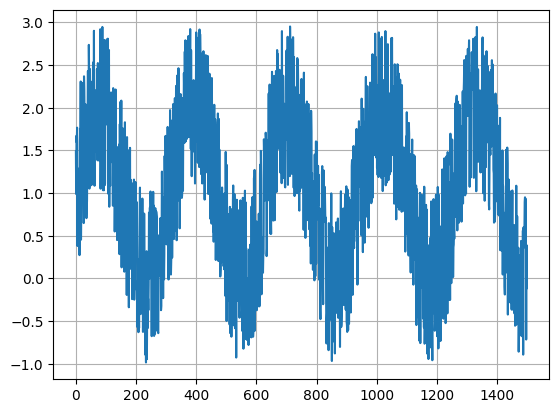

In [3]:
data = 1500 
t = np.arange(0, data)
x = np.sin(0.02 * t) + np.random.rand(data) * 2
fig, ax = plt.subplots()
ax.plot(t, x)
ax.grid()

In [4]:
def convertToDataset(data, step=3):
    X, Y = [], []
    for i in range(len(data) - step):
        d = i + step
        X.append(data[i:d])
        Y.append(data[d])
    return np.array(X, dtype='float32'), np.array(Y, dtype='float32')

## Create train/test dataset

In [5]:
validation_split = int(data * 0.8)
step = 10
X, Y = convertToDataset(x, step)
x_train = X[:validation_split]
x_test = X[validation_split:]

y_train = Y[:validation_split]
y_test = Y[validation_split:]

Shape should be
$$
    (samples, steps, features)
$$

In [6]:
x_train = np.reshape(x_train, (-1, step, 1))
x_test = np.reshape(x_test, (-1, step, 1)) 

In [7]:
print(f'x_train\'s shape is {x_train.shape}')
print(f'x_test\'s shape is {x_test.shape}')

x_train's shape is (1200, 10, 1)
x_test's shape is (290, 10, 1)


## Define the model

In [8]:
model = keras.Sequential([
    BidirectionalRNN(64, activation='tanh'),
    keras.layers.Dense(1)
])

model.compile(
    loss='mean_squared_error',
    optimizer='rmsprop',
)

In [9]:
history = model.fit(
    x_train,
    y_train,
    epochs=100,
    batch_size=16,
    validation_data=(x_test, y_test)
)

Epoch 1/100


I0000 00:00:1711920796.580433  474098 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


75/75 [==============================] - 3s 13ms/step - loss: 0.4451 - val_loss: 0.3689
Epoch 2/100
75/75 [==============================] - 1s 7ms/step - loss: 0.4062 - val_loss: 0.3756
Epoch 3/100
75/75 [==============================] - 1s 7ms/step - loss: 0.4026 - val_loss: 0.4611
Epoch 4/100
75/75 [==============================] - 1s 7ms/step - loss: 0.4009 - val_loss: 0.3722
Epoch 5/100
75/75 [==============================] - 1s 7ms/step - loss: 0.4007 - val_loss: 0.3620
Epoch 6/100
75/75 [==============================] - 1s 7ms/step - loss: 0.4028 - val_loss: 0.3728
Epoch 7/100
75/75 [==============================] - 1s 7ms/step - loss: 0.3913 - val_loss: 0.3906
Epoch 8/100
75/75 [==============================] - 1s 7ms/step - loss: 0.3942 - val_loss: 0.3970
Epoch 9/100
75/75 [==============================] - 1s 7ms/step - loss: 0.3916 - val_loss: 0.3708
Epoch 10/100
75/75 [==============================] - 1s 7ms/step - loss: 0.3859 - val_loss: 0.3843
Epoch 11/100
75/75 [

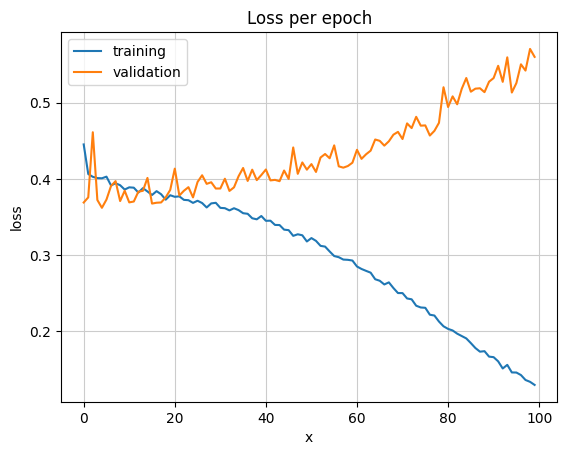

In [10]:
fig, ax = plt.subplots()
ax.plot(history.epoch, history.history['loss'], label='training')
ax.plot(history.epoch, history.history['val_loss'], label='validation')
ax.set_title('Loss per epoch')
ax.set_xlabel('x')
ax.set_ylabel('loss')
ax.grid(c='#ccc')
plt.legend()

10/10 [==============================] - 0s 3ms/step


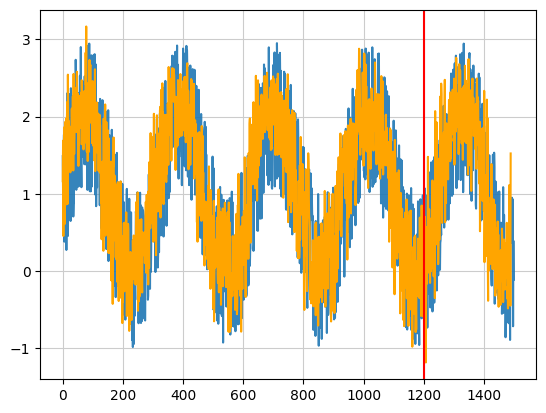

In [11]:
trainPredict = model.predict(x_train)
testPredict= model.predict(x_test)
predicted=np.concatenate((trainPredict,testPredict),axis=0)

plt.plot(x, alpha=0.9)
plt.plot(predicted, alpha=1, c='orange')
plt.axvline(len(x_train), c="r")
plt.grid(c='#ccc')
plt.show()

## With different sequence length

In [12]:
validation_split = int(data * 0.8)
train_step = 10
test_step = 20

x_train = x[:validation_split]
x_test = x[validation_split:]

In [13]:
x_train, y_train = convertToDataset(x_train, train_step)
x_test, y_test = convertToDataset(x_test, test_step)

x_train = np.reshape(x_train, (-1, train_step, 1))
x_test = np.reshape(x_test, (-1, test_step, 1)) 

print(f'x_train\'s shape is {x_train.shape}')
print(f'x_test\'s shape is {x_test.shape}')

x_train's shape is (1190, 10, 1)
x_test's shape is (280, 20, 1)


In [14]:
model = keras.Sequential([
    BidirectionalRNN(64, input_shape=(None, 1), activation='tanh'),
    keras.layers.Dense(1)
])

model.compile(
    loss='mean_squared_error',
    optimizer='rmsprop',
)

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_rnn_1 (Bidir  (None, 128)               8448      
 ectionalRNN)                                                    
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 8577 (33.50 KB)
Trainable params: 8577 (33.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [15]:
history = model.fit(
    x_train, y_train,
    batch_size=16,
    epochs=100,
    validation_data=(x_test, y_test)
)

Epoch 1/100
75/75 [==============================] - 2s 11ms/step - loss: 0.4293 - val_loss: 0.4574
Epoch 2/100
75/75 [==============================] - 1s 9ms/step - loss: 0.4115 - val_loss: 0.4296
Epoch 3/100
75/75 [==============================] - 1s 9ms/step - loss: 0.3970 - val_loss: 0.3971
Epoch 4/100
75/75 [==============================] - 1s 9ms/step - loss: 0.3994 - val_loss: 0.4172
Epoch 5/100
75/75 [==============================] - 1s 8ms/step - loss: 0.3916 - val_loss: 0.4859
Epoch 6/100
75/75 [==============================] - 1s 9ms/step - loss: 0.3898 - val_loss: 0.4537
Epoch 7/100
75/75 [==============================] - 1s 9ms/step - loss: 0.3858 - val_loss: 0.4733
Epoch 8/100
75/75 [==============================] - 1s 8ms/step - loss: 0.3848 - val_loss: 0.4523
Epoch 9/100
75/75 [==============================] - 1s 8ms/step - loss: 0.3852 - val_loss: 0.4801
Epoch 10/100
75/75 [==============================] - 1s 10ms/step - loss: 0.3885 - val_loss: 0.4230
Epoch 1

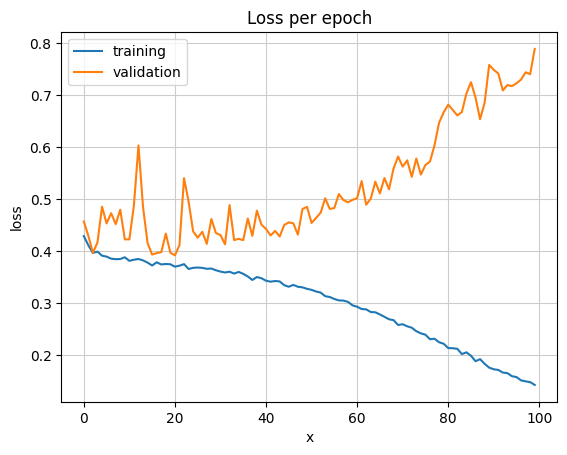

In [16]:
fig, ax = plt.subplots()
ax.plot(history.epoch, history.history['loss'], label='training')
ax.plot(history.epoch, history.history['val_loss'], label='validation')
ax.set_title('Loss per epoch')
ax.set_xlabel('x')
ax.set_ylabel('loss')
ax.grid(c='#ccc')
plt.legend()

9/9 [==============================] - 0s 3ms/step


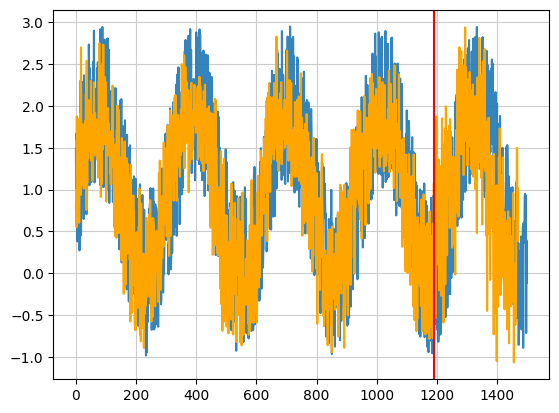

In [17]:
trainPredict = model.predict(x_train)
testPredict= model.predict(x_test)
predicted=np.concatenate((trainPredict,testPredict),axis=0)

plt.plot(x, alpha=0.9)
plt.plot(predicted, alpha=1, c='orange')
plt.axvline(len(x_train), c="r")
plt.grid(c='#ccc')
plt.show()